Instalando e importando os requisitos

In [22]:
%pip install -r ./requirements.txt -q
%pip install seaborn -q
from app.modelo.resnet50 import Resnet50
from app.modelo.svm import SVM
from app.modelo.imagem_rgb import ImagemRGB
import os
import pandas
import time
import datetime
import matplotlib
import matplotlib.pyplot
import seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Contando o tempo

Abrindo o DataFrame e setando o caminho da imagem de destino e carregando o modelo

In [2]:
# Carregando o arquivo CSV
## Definindo o caminho do arquivo CSV para quando mudar de diretório não houver problemas
if not 'csv_file_path' in locals(): # Evita definir o caminho do arquivo CSV duas vezes
    csv_file_path = os.path.join(os.getcwd(), "classifications.csv")
data_frame = pandas.read_csv(csv_file_path)

# Definindo o diretório das imagens
if not 'destination_image_dir' in locals(): # Evita definir o diretório das imagens duas vezes
    destination_image_dir = os.path.join(os.getcwd(), "dataset_converted")

# Carregando o modelo
## Mudando o diretório para o diretório app para contornar erro ao importar a inteligência do modelo
if not 'app' in os.getcwd(): # Evita mudar o diretório duas vezes
    os.chdir('./app')
modelo_resnet50 = Resnet50()
modelo_svm = SVM()

In [3]:
data_frame

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
0,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,1,SCC,792,462
1,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,2,SCC,601,678
2,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,3,SCC,363,467
3,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,4,SCC,599,437
4,400,9ae8a4edde40219bad6303cebc672ee4.png,10.6084/m9.figshare.12230906,5,Negative for intraepithelial lesion,1186,450
...,...,...,...,...,...,...,...
11529,1,be340ee72689dfe3f8dc9c24de6127f4.png,10.6084/m9.figshare.12229511,11530,LSIL,618,407
11530,1,be340ee72689dfe3f8dc9c24de6127f4.png,10.6084/m9.figshare.12229511,11531,LSIL,607,374
11531,1,be340ee72689dfe3f8dc9c24de6127f4.png,10.6084/m9.figshare.12229511,11532,LSIL,707,251
11532,1,be340ee72689dfe3f8dc9c24de6127f4.png,10.6084/m9.figshare.12229511,11533,LSIL,579,246


Calculando o tempo

In [5]:
dados_tempo = []
labels_tempo = ['Caminho', 'Algoritmo', 'Tempo', 'Classe']
if not os.path.exists(destination_image_dir):
    os.mkdir(destination_image_dir)
indice = 0
for _, row in data_frame.iterrows():
    classe = row['bethesda_system']
    diretorio_classe = os.path.join(destination_image_dir, classe)
    if not os.path.exists(diretorio_classe):
        os.mkdir(diretorio_classe)
    
    destination_image_path = os.path.join(diretorio_classe, "{}.png".format(row['cell_id']))
    
    if os.path.exists(destination_image_path):
        for _ in range(1):
            # Abrindo a imagem
            imagem = ImagemRGB.from_file(destination_image_path)
            
            # Calculando o tempo do SVM
            inicio = time.time_ns()
            modelo_svm.predict(imagem)
            fim = time.time_ns()
            tempo_svm = (fim - inicio)/10**9
            dados_tempo.append((destination_image_path, 'SVM', tempo_svm, classe))

            # Calculando o tempo do Resnet50
            inicio = time.time_ns()
            modelo_resnet50.predict(imagem)
            fim = time.time_ns()
            tempo_resnet50 = (fim - inicio)/10**9
            dados_tempo.append((destination_image_path, 'Resnet50', tempo_resnet50, classe))
            indice = indice + 1
            print(indice, "/", len(data_frame))

tempo = pandas.DataFrame(dados_tempo, columns=labels_tempo)
tempo.to_csv("tempo_{}_{}.csv".format(indice, datetime.datetime.now().strftime("%Y%m%d_%H%M%S")))
            


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
3 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
4 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
5 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
6 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
7 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
8 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
9 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
10 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
11 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
12 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
13 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
14 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
15 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
16 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
17 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
18 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
19 / 11534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
20 / 11534
1/1 ━━━━━━━━

KeyboardInterrupt: 

# Gerando gráficos

In [17]:
tempo = pandas.read_csv("tempo_5581_20240615_173954.csv")

In [18]:
tempo

,Unnamed: 0,Caminho,Algoritmo,Tempo,Classe
0,0,C:\Users\henrique\Trabalho_Pratico_-_Processam...,SVM,0.023999,LSIL
1,1,C:\Users\henrique\Trabalho_Pratico_-_Processam...,Resnet50,1.610002,LSIL
2,2,C:\Users\henrique\Trabalho_Pratico_-_Processam...,SVM,0.023001,LSIL
3,3,C:\Users\henrique\Trabalho_Pratico_-_Processam...,Resnet50,0.154002,LSIL
4,4,C:\Users\henrique\Trabalho_Pratico_-_Processam...,SVM,0.024984,LSIL
...,...,...,...,...,...
11157,11157,C:\Users\henrique\Trabalho_Pratico_-_Processam...,Resnet50,0.179003,ASC-US
11158,11158,C:\Users\henrique\Trabalho_Pratico_-_Processam...,SVM,0.027999,ASC-US
11159,11159,C:\Users\henrique\Trabalho_Pratico_-_Processam...,Resnet50,0.176004,ASC-US
11160,11160,C:\Users\henrique\Trabalho_Pratico_-_Processam...,SVM,0.029994,ASC-US


Gerando gráfico de barra comparando o ResNet50 e o SVM

In [19]:
dados_media_algoritmo_tempo_execucao = {}
for index, row in tempo.iterrows():
    if not row['Algoritmo'] in dados_media_algoritmo_tempo_execucao:
        dados_media_algoritmo_tempo_execucao[row['Algoritmo']] = []
    else:
        dados_media_algoritmo_tempo_execucao[row['Algoritmo']].append(row['Tempo'])

dados_grafico_algoritmo_tempo_execucao = {
    'Algoritmo': [],
    'Tempo': []
}

for algoritmo, tempo_ in dados_media_algoritmo_tempo_execucao.items():
    dados_grafico_algoritmo_tempo_execucao['Algoritmo'].append(algoritmo)
    dados_grafico_algoritmo_tempo_execucao['Tempo'].append(sum(tempo_)/len(tempo_))

<BarContainer object of 2 artists>

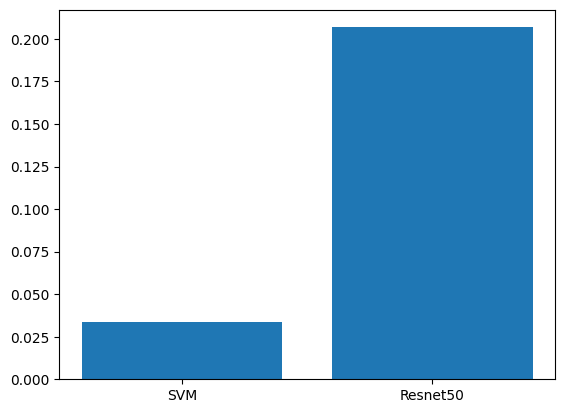

In [20]:
matplotlib.pyplot.figure()
matplotlib.pyplot.bar(dados_grafico_algoritmo_tempo_execucao['Algoritmo'], dados_grafico_algoritmo_tempo_execucao['Tempo'])

Gerando gráfico comparando o ResNet50 e o SVM por classe

In [21]:
dados_grafico_algoritmo_classe_tempo_execucao = {}
for index, row in tempo.iterrows():
    if not (row['Algoritmo'], row['Classe']) in dados_grafico_algoritmo_classe_tempo_execucao:
        dados_grafico_algoritmo_classe_tempo_execucao[(row['Algoritmo'], row['Classe'])] = []
    else:
        dados_grafico_algoritmo_classe_tempo_execucao[(row['Algoritmo'], row['Classe'])].append(row['Tempo'])

dados_grafico_algoritmo_classe_tempo_execucao_media = {
    'Algoritmo': [],
    'Classe': [],
    'Tempo': []
}

for (algoritmo, classe), tempo in dados_grafico_algoritmo_classe_tempo_execucao.items():
    dados_grafico_algoritmo_classe_tempo_execucao_media['Algoritmo'].append(algoritmo)
    dados_grafico_algoritmo_classe_tempo_execucao_media['Classe'].append(classe)
    dados_grafico_algoritmo_classe_tempo_execucao_media['Tempo'].append(sum(tempo)/len(tempo))

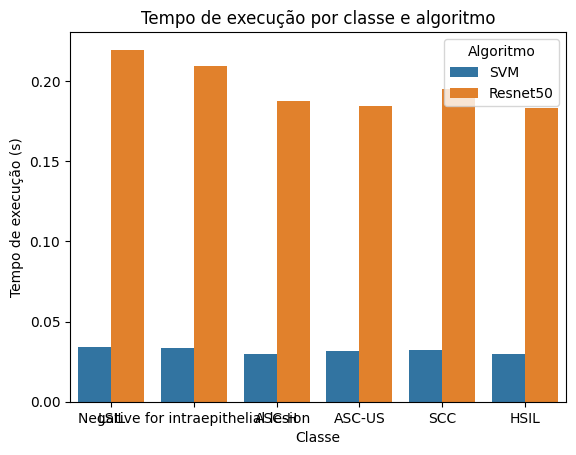

In [23]:
matplotlib.pyplot.figure()
seaborn.barplot(x='Classe', y='Tempo', hue='Algoritmo', data=dados_grafico_algoritmo_classe_tempo_execucao_media)
matplotlib.pyplot.title('Tempo de execução por classe e algoritmo')
matplotlib.pyplot.xlabel('Classe')
matplotlib.pyplot.ylabel('Tempo de execução (s)')
matplotlib.pyplot.legend(title='Algoritmo')
matplotlib.pyplot.show()